<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

In [1]:
from deepul.hw4_helper import *
import warnings

warnings.filterwarnings('ignore')

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import math
import os


In [3]:
torch.cuda.empty_cache()

In [3]:
@torch.no_grad()
def test_loss(test_loader, model):
    count, loss = 0, 0

    model.eval()
    with torch.no_grad():
        for x in test_loader:
            x = x.to(device)
            loss += model.loss(x).item()
            count += 1
    
    return loss / count
        

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

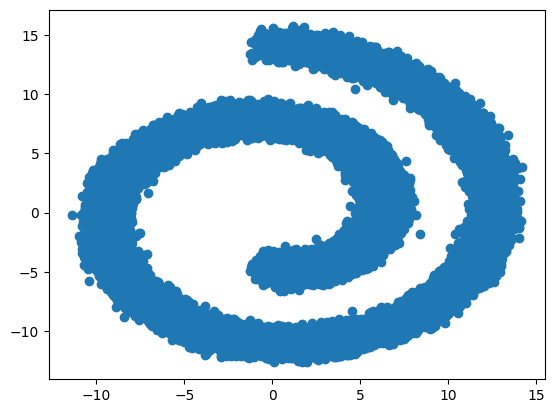

In [6]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [9]:

class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(*[nn.Linear(3, 64), nn.ReLU(),
                                     nn.Linear(64, 64), nn.ReLU(),
                                     nn.Linear(64, 64), nn.ReLU(),
                                     nn.Linear(64, 2)])
    
    def forward(self, x_t, t):
        X = torch.cat([x_t, t], dim=1)
        return self.layer(X)  # (B, 2)
    
    def loss(self, x):
        
        B, _ = x.shape
        t = torch.rand(B).unsqueeze(dim = 1).to(device)
        alpha_t = torch.cos(t  * np.pi / 2).to(device)
        var = torch.sin(t  * np.pi / 2).to(device)

        noise = torch.randn_like(x).to(device)

        x_t = alpha_t * x + var * noise

        eps = self.forward(x_t, t)

        return  F.mse_loss(eps, noise)
    
    @torch.no_grad()
    def sample(self, numbers, step):

        ts = np.linspace(1 - 1e-4, 1e-4, step + 1)
        X = torch.randn((numbers, 2)).to(device)
        
        for i in range(step):

            t = torch.full((numbers, 1), ts[i], device = device)
            tt = torch.full((numbers, 1), ts[i + 1], device = device)

            eps = self.forward(X, t)
            noise = torch.randn_like(X).to(device)
            
            alpha_t = torch.cos(t * np.pi / 2).to(device)
            alpha_t_minus_one = torch.cos(tt * np.pi / 2).to(device)
            var_t = torch.sin(t * np.pi / 2).to(device)
            var_t_minus_one = torch.sin(tt * np.pi / 2).to(device)

            eta = var_t_minus_one / var_t * torch.sqrt(1 - torch.pow(alpha_t / alpha_t_minus_one,2)).to(device)

            result = torch.where(var_t_minus_one * var_t_minus_one - eta * eta < 0, 
                     torch.tensor(0.0, device=device), 
                     var_t_minus_one * var_t_minus_one - eta * eta)
                
            X = alpha_t_minus_one * (X - var_t * eps) / alpha_t + torch.sqrt(result) * eps + eta * noise

        return X
    
    @torch.no_grad()
    def sample2(self, numbers, step):

        ts = np.linspace(1 - 1e-4, 1e-4, step + 1)
        X = torch.randn((numbers, 2)).to(device)
        
        for i in range(step):

            t = torch.full((numbers, 1), ts[i], device = device)
            tt = torch.full((numbers, 1), ts[i + 1], device = device)

            eps = self.forward(X, t)
            noise = torch.randn_like(X).to(device)
            
            alpha_t_bar = torch.cos(t * np.pi / 2).to(device)
            alpha_t_minus_one_bar = torch.cos(tt * np.pi / 2).to(device)

            alpha_t = alpha_t_bar / alpha_t_minus_one_bar

            niu = 1 / torch.sqrt(alpha_t) * X - (1 - alpha_t) / (torch.sqrt((1 - alpha_t_bar) * alpha_t))  * eps
            cegma = (1 - alpha_t) * (1 - alpha_t_minus_one_bar) / (1 - alpha_t_bar)

            X = niu + torch.sqrt(cegma) * noise

        return X

In [7]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """

    print(train_data.shape)
    '''归一化'''
    mean = np.mean(train_data, axis = 0)
    std = np.std(train_data, axis = 0)
    train_data = (train_data - mean) / std

    mean = np.mean(test_data, axis = 0)
    std = np.std(test_data, axis = 0)
    test_data = (test_data - mean) / std

    lr, batch_size, epochs = 1e-3, 1024, 100
    model = Diffusion().to(device)
    optimizer = optim.Adam(model.parameters(), lr = lr)

    train_loader = DataLoader(train_data, batch_size= batch_size, shuffle = True, num_workers=4)
    test_loader = DataLoader(test_data, batch_size= batch_size, shuffle = False, num_workers=4)
    train_losses, test_losses, all_samples = [], [test_loss(test_loader, model)], []

    model.load_state_dict(torch.load(os.path.join(
            "Checkpoints", "ckpt_q1_.pt"), map_location=device))
    
    # for epoch in range(epochs):
    #     print(f"epoch : {epoch}", end="     ")

    #     model.train()
    #     for x in train_loader:
            
    #         x = x.to(device)
    #         optimizer.zero_grad()
    #         loss = model.loss(x)
    #         loss.backward()
    #         optimizer.step()
    #         train_losses.append(loss.item())
        
    #     test_losses.append(test_loss(test_loader, model))
    #     print(f"loss : {test_losses[-1]}")

    # torch.save(model.state_dict(), os.path.join(
    #     'Checkpoints', 'ckpt_' + "q1" + "_.pt"))
        

    num_sample = 2000
    T = np.power(2, np.linspace(0, 9, 9)).astype(int)
    print(T[-1])
    for t in T:
        sample = model.sample2(num_sample, t).cpu().numpy()
        all_samples.append(sample)
    print(all_samples[0][0])
    return np.array(train_losses), np.array(test_losses), np.array(all_samples)

(100000, 2)
512
[-0.213974  7.054508]
Final Test Loss: 0.9788


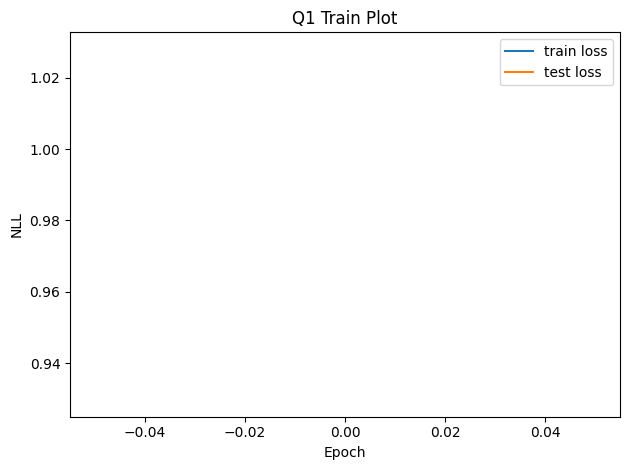

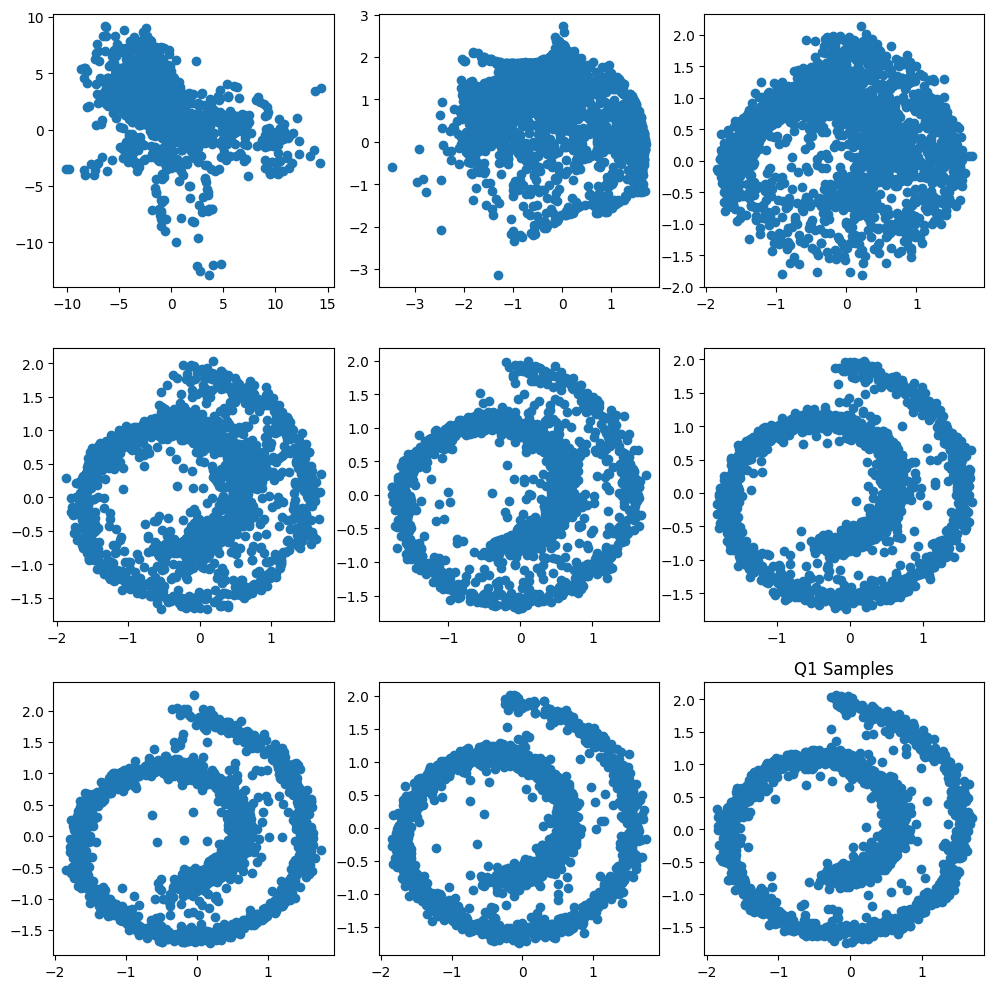

In [10]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

In [ ]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

In [5]:
from torch.optim.lr_scheduler import _LRScheduler

class GradualWarmupScheduler(_LRScheduler):
    def __init__(self, optimizer, multiplier, warm_epoch, after_scheduler=None):
        self.multiplier = multiplier
        self.total_epoch = warm_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        self.last_epoch = None
        self.base_lrs = None
        super().__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    print("!!!!!!!!")
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


    '''step操作并且如果还没有完成将会调度get_lr获得学习率, 然后再以此进行更新 会将self.last_epoch设置为当前epoch'''
    def step(self, epoch=None, metrics=None):
        if self.finished and self.after_scheduler:
            if epoch is None:
                self.after_scheduler.step(None)
            else:
                self.after_scheduler.step(epoch - self.total_epoch)
        else:
            return super(GradualWarmupScheduler, self).step(epoch)

In [13]:
torch.cuda.empty_cache()

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [41]:
from torch.nn import init
import math

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# max_period = 1000
def timestep_embedding(timesteps, dim, max_period = 10000):
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(0, half, dtype = torch.float32) / half).to(device)
    
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], axis = -1)

    if dim % 2 == 1:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim = -1)
    
    return embedding  # (B, dim)


class Embedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.layer = nn.Sequential(*[nn.Linear(dim, 4 * dim), 
                                     Swish(), nn.Linear(dim * 4, 4 * dim)])
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, x):
        return self.layer(x) # (B, 4 * dim)


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, tem_channels):
        super().__init__()
        self.layer = nn.Sequential(*[nn.GroupNorm(num_groups=8, num_channels=in_channels),
                                     Swish(),
                                     nn.Conv2d(in_channels, out_channels, 3, padding=1)])
        self.layer3 = nn.Linear(tem_channels, out_channels)
        self.layer2 = nn.Sequential(*[nn.GroupNorm(num_groups=8, num_channels=out_channels),
                                     Swish(),
                                     nn.Conv2d(out_channels, out_channels, 3, padding=1)])


        # kernel_size = 3, padding = 1
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else :
            self.shortcut = nn.Identity()


        self.out_channels = out_channels
        self.initialize()


    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.layer[-1].weight)
        init.zeros_(self.layer[-1].bias)
        init.xavier_uniform_(self.layer2[-1].weight)
        init.zeros_(self.layer2[-1].bias)


    def forward(self, x, tem):
        h = self.layer(x)
        
        tem = self.layer3(tem) 
        tem = tem[:, :, None, None]
        h += tem
        h = self.layer2(h)

        return self.shortcut(x) + h  # (B, out_channels, H, W)

class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Conv2d(in_channels, out_channels, 3, stride = 2, padding = 1)
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
                
    def forward(self, x, tem):
        return self.layer(x) 

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.layer = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, x, tem):
        x = F.interpolate(x, scale_factor = 2, mode = 'nearest')
        return self.layer(x)


class UNet(nn.Module):
    def __init__(self, in_channels, hidden_dims, block_per_dim, num_groups): 
        super().__init__()
        self.hidden_dims = hidden_dims
        self.block_pre_dim = block_per_dim
        self.emb_channels = 4 * hidden_dims[0]
        self.embedding = Embedding(hidden_dims[0])

        self.head = nn.Conv2d(in_channels, hidden_dims[0], kernel_size=3, padding=1)

        pre_ch = hidden_dims[0]
        channels = [pre_ch]

        self.DownBlock = nn.ModuleList()

        for (i, cur_dim) in enumerate(hidden_dims):
            for _ in range(block_per_dim):

                self.DownBlock.append(ResNetBlock(pre_ch, cur_dim, self.emb_channels))
                pre_ch = cur_dim
                channels.append(pre_ch)

            if i != len(hidden_dims) - 1:
                self.DownBlock.append(Downsample(pre_ch, pre_ch))
                channels.append(pre_ch)

        self.Middle = nn.Sequential(*[ResNetBlock(pre_ch, pre_ch, self.emb_channels) for i in range(2)])

        self.UpBlock = nn.ModuleList()
        for i, cur_dim in list(enumerate(hidden_dims))[::-1]:
            for j in range(block_per_dim + 1):
                ch = channels.pop()
                self.UpBlock.append(ResNetBlock(pre_ch + ch, cur_dim, self.emb_channels))
                pre_ch = cur_dim
                if i and j == block_per_dim:
                    self.UpBlock.append(Upsample(pre_ch, pre_ch))

        self.tail = nn.Sequential(*[nn.GroupNorm(num_groups, pre_ch), Swish(),
                                    nn.Conv2d(pre_ch, in_channels, 3, padding = 1)])
        self.initialize()
        
    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain = 1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        emb = timestep_embedding(t, self.hidden_dims[0]) # (B, 64 * 4)
        emb = self.embedding(emb) # (B, dim)

        h = self.head(x)
        hs = [h]
        for layer in self.DownBlock:
            h = layer(h, emb)
            hs.append(h)
        
        for layer in self.Middle:
            h = layer(h, emb)

        for layer in self.UpBlock:
            if isinstance(layer, ResNetBlock):
                h = torch.cat([h, hs.pop()], dim = 1)
            h = layer(h, emb)
        h = self.tail(h)

        assert(len(hs) == 0)
        
        return h


        

In [37]:
class Diffusion(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def loss(self, x):
        
        B, _, _, _ = x.shape
        t = torch.rand(B).to(device)
        tt = t.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        alpha_t = torch.cos(tt  * np.pi / 2.).to(device)
        var = torch.sin(tt  * np.pi / 2.).to(device)

        noise = torch.randn_like(x).to(device)
        x_t = alpha_t * x + var * noise

        eps = self.model(x_t, t)

        return  F.mse_loss(eps, noise)
    
    @torch.no_grad()
    def sample(self, numbers, step, shape):

        ts = np.linspace(1 - 1e-4, 1e-4, step + 1)
        X = torch.randn((shape)).to(device)
        
        for i in range(step):

            t = torch.full((numbers, ), ts[i], device = device)
            tt = torch.full((numbers, ), ts[i + 1], device = device)

            eps = self.model(X, t)

            t = t.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            tt = tt.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            
            noise = torch.randn_like(X).to(device)
            
            alpha_t = torch.cos(t * np.pi / 2).to(device)
            alpha_t_minus_one = torch.cos(tt * np.pi / 2).to(device)
            var_t = torch.sin(t * np.pi / 2).to(device)
            var_t_minus_one = torch.sin(tt * np.pi / 2).to(device)

            eta = var_t_minus_one / var_t * torch.sqrt(1 - torch.pow(alpha_t / alpha_t_minus_one, 2)).to(device)

            result = torch.where(var_t_minus_one * var_t_minus_one - eta * eta < 0, 
                     torch.tensor(0.0, device=device), 
                     var_t_minus_one * var_t_minus_one - eta * eta)
            
            X_0 = torch.clip((X - var_t * eps) / alpha_t, -1, 1)  # important!!!!
            X = alpha_t_minus_one * X_0 + torch.sqrt(result) * eps + eta * noise

            assert torch.isnan(X).int().sum() == 0, "nan in tensor"

        return torch.clip(X, -1, 1)

    @torch.no_grad()
    def sample2(self, numbers, step, shape):

        ts = np.linspace(1 - 1e-4, 1e-4, step + 1)
        X = torch.randn((shape)).to(device)
        
        for i in range(step):

            t = torch.full((numbers, ), ts[i], device = device)
            tt = torch.full((numbers, ), ts[i + 1], device = device)
            eps = self.model(X, t)

            t = t.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            tt = tt.unsqueeze(1).unsqueeze(2).unsqueeze(3)


            noise = torch.randn_like(X).to(device)
            
            alpha_t_bar = torch.cos(t * np.pi / 2).to(device)
            alpha_t_minus_one_bar = torch.cos(tt * np.pi / 2).to(device)

            alpha_t = alpha_t_bar / alpha_t_minus_one_bar

            niu = 1 / torch.sqrt(alpha_t) * X - (1 - alpha_t) / torch.sqrt((1 - alpha_t_bar) * alpha_t)  * eps
            cegma = (1 - alpha_t) * (1 - alpha_t_minus_one_bar) / (1 - alpha_t_bar)

            X = niu + torch.sqrt(cegma) * noise
            X = torch.clip(X, -1, 1)
            assert torch.isnan(X).int().sum() == 0, "nan in tensor"

        return torch.clip(X, -1, 1)


In [44]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
        The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
        for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
        1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    """ YOUR CODE HERE """


    B, H, W, C = train_data.shape
    print((B, H, W, C))
    train_data = torch.tensor(train_data).permute(0, 3, 1, 2).float() * 2 - 1
    test_data = torch.tensor(test_data).permute(0, 3, 1, 2).float() * 2 - 1

    print(torch.all((train_data >= -1) & (train_data <= 1)))
    hidden_dims, block_per_dim, lr, batch_size, epochs = [64, 128, 256, 512], 2, 1e-4, 256, 60

    model = UNet(3, hidden_dims, block_per_dim, 8)
    DDPM = Diffusion(model).to(device)
    optimizer = optim.Adam(DDPM.parameters(), lr = lr)

    cosineScheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer, T_max= epochs, eta_min = 0, last_epoch= -1
    )
    # warmUpScheduler = GradualWarmupScheduler(
    #     optimizer = optimizer,
    #     multiplier = 2.0,
    #     warm_epoch = epochs // 10,
    #     after_scheduler = cosineScheduler
    # )

    model.load_state_dict(torch.load(os.path.join(
             "Checkpoints", "ckpt_q2_" + str(30) + ".pt"), map_location=device))
    
    trainloader = DataLoader(train_data, batch_size= batch_size, shuffle= True, num_workers= 4)
    testloader = DataLoader(test_data, batch_size= batch_size, shuffle= False, num_workers= 4)
    trainlosses, testlosses, samples = [], [test_loss(testloader, DDPM)], []

    print(testlosses[-1])
    # cur_epoch = 0
    # if cur_epoch != 0 :
    #     model.load_state_dict(torch.load(os.path.join(
    #          "Checkpoints", "ckpt_q2_" + str(cur_epoch) + ".pt"), map_location=device))
    #     cur_epoch += 1


    for epoch in range(epochs):
        print(f"epoch : {epoch}", end = "      ")

        DDPM.train()
        for x in trainloader:

            x = x.to(device)
            optimizer.zero_grad()
            loss = DDPM.loss(x)
            loss.backward()

            # 梯度裁剪，使得梯度不会超过1.0
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), 1.0
            )
            optimizer.step()
            trainlosses.append(loss.item())

        cosineScheduler.step()
        testlosses.append(test_loss(testloader, DDPM))
        print(testlosses[-1])

        torch.save(model.state_dict(), os.path.join(
            'Checkpoints', 'ckpt_' + 'q2' + '_' + str(30) + ".pt"))

    T = np.power(2, np.linspace(1, 10, num=10, dtype=int)).astype(int)
    num_samplese = 10
    for (id, i) in enumerate(T):
        sample = torch.clamp(DDPM.sample(num_samplese, i, (num_samplese, C, W, H)).permute(0, 2, 3, 1) * 0.5 + 0.5, 0, 1).squeeze(0).cpu().numpy()
        samples.append(sample)
        print(f"The {id}'s sampling has been finished")

    print(np.array(samples).shape)

    return np.array(trainlosses), np.array(testlosses), np.array(samples)

In [29]:
print(np.linspace(1, 10, 11))
T = np.power(2, np.linspace(1, 10, num=10, dtype=int)).astype(int)
T

[ 1.   1.9  2.8  3.7  4.6  5.5  6.4  7.3  8.2  9.1 10. ]


array([   2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
tensor(True)
0.06507709715515375
The 0's sampling has been finished
The 1's sampling has been finished
The 2's sampling has been finished
The 3's sampling has been finished
The 4's sampling has been finished
The 5's sampling has been finished
The 6's sampling has been finished
The 7's sampling has been finished
The 8's sampling has been finished
The 9's sampling has been finished
(10, 10, 32, 32, 3)
Final Test Loss: 0.0651


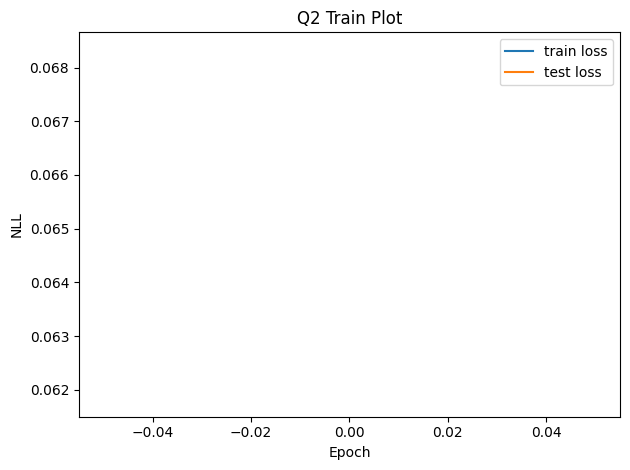

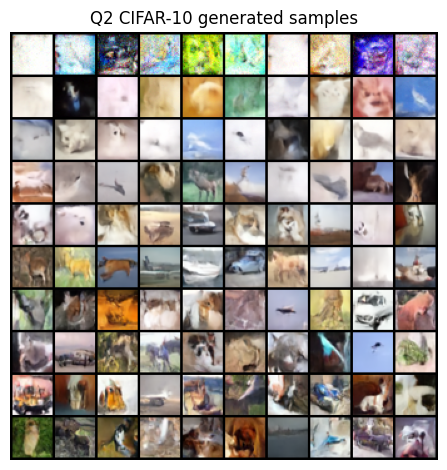

In [45]:
q2_save_results(q2)

## 在训练过程中遇到的问题

    1.当时设置lr = 1e-3时，loss没有变化，总是为1
      ->   发现当设置lr = 1e-4时有较好的效果（所以不一定是将学习率调大，也有可能是调小比较好）
    2.最初的sample采样出来是噪声，但是发现另一种不用判断非负的采样方法时，可以成像，但是效果并不是很好
      ->   即在最初的采样方法下，利用 clip来限制预测出的x0处于[-1, 1]之间时效果最好

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

100%|██████████| 170498071/170498071 [00:52<00:00, 3226812.84it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


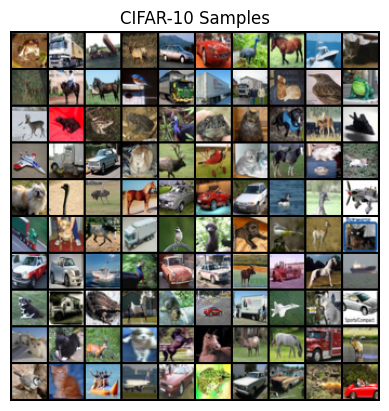

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [5]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [12]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """

    """ YOUR CODE HERE """
    images = np.transpose(images, (0, 3, 1, 2))

    latent_space = vae.encode(images)
    
    scale_factor = latent_space.std()
    
    reconstruct = vae.decode(latent_space)

    reconstruct = reconstruct.permute(0, 2, 3, 1).clip(0, 1).unsqueeze(1)
    images = torch.tensor(images).permute(0, 2, 3, 1).unsqueeze(1)
    # print(images.shape)
    # print(reconstruct.shape)
    autoencoded_images = torch.cat([images, reconstruct.cpu()], dim = 1)
    
    print(autoencoded_images.shape)
    autoencoded_images = autoencoded_images[:50, :, :, :, :]

    
    return np.array(autoencoded_images), scale_factor

Files already downloaded and verified


Files already downloaded and verified
tensor(1.0453, device='cuda:0')
tensor(5.2190, device='cuda:0') tensor(-4.2530, device='cuda:0')
torch.Size([1000, 2, 32, 32, 3])


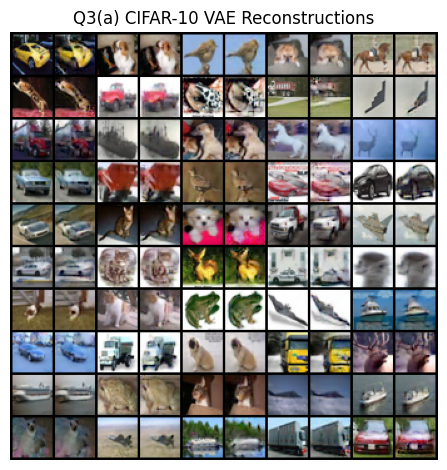

Scale factor: 1.0453


In [13]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)  # (2, grid_size, grid_size)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [5]:
@torch.no_grad()
def test_loss(test_loader, model):
    count, loss = 0, 0

    model.eval()
    with torch.no_grad():
        for (x, c) in test_loader:
            x = x.to(device)
            c = c.to(device)
            loss += model.loss(x, c).item()
            count += 1
    
    return loss / count
        

In [6]:
from matplotlib import axis
from timm.models.vision_transformer import Attention, Mlp, PatchEmbed

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):

    '''
        pos : (1, H, H) -> (M, )

        return : (M, D)
    '''
    assert embed_dim % 2 == 0 
    omega = np.arange(embed_dim // 2, dtype = np.float32)
    omega /= embed_dim / 2.0
    omega = 1. / 10000**omega  # (D/2, )

    pos = pos.reshape(-1)  # (M, )
    out = np.einsum('m, d -> md', pos, omega) # (M, D/2)

    emb_sin = np.sin(out)
    emb_cos = np.cos(out)

    emb = np.concatenate([emb_sin, emb_cos], axis = 1)

    return emb

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):

    '''
        grid: (2, H, W)

        return (H * W, D)
    '''
    assert embed_dim % 2 == 0

    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0]) # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])

    emb = np.concatenate([emb_h, emb_w], axis = 1)

    return emb # (H*W, D)

def get_2d_sincos_pos_embed(embed_dim, grid_size):

    '''
        grid_size : W, H (same)

        return : (H*W, D)
    '''

    grid_h = np.arange(grid_size, dtype = np.float32)
    grid_w = np.arange(grid_size, dtype = np.float32)
    grid = np.meshgrid(grid_h, grid_w) 
    grid = np.stack(grid, axis = 0) # (2, H, H)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_emb = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)

    return pos_emb 



class TimestepEmbedder(nn.Module):

    def __init__(self, hidden_dim, frequency_embedding_size = 256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.frequency_embedding_size = frequency_embedding_size

    
    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        
        '''
            t : a indices tensor of (D)

            return : (D, dim)
            
            openAI:
            https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        '''


        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(0, half, dtype = torch.float32) / half
        ).to(device)

        args = t[:, None].float() * freqs[None]  # (B, dim/2)
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim = -1)

        if dim % 2 == 1:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim = 1)
        
        return embedding
    
    def forward(self, t):
        '''
            t : a indices tensor of (D)

            return (D, hidden_dim)
        '''
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb



class LabelEmbedder(nn.Module):

    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0

        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids = None):
        '''
            class-free-guidance
        '''
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device = device) < self.dropout_prob
        else :
            drop_ids = force_drop_ids == 1

        # torch.where(check, x, y)       x if check  eles y
        labels = torch.where(drop_ids, self.num_classes, labels)

        return labels
        
    def forward(self, labels, train, force_drop_ids = None):


        use_dropout = self.dropout_prob > 0

        if (train and use_dropout) or force_drop_ids is not None:
            labels = self.token_drop(labels, force_drop_ids)
        
        embedding = self.embedding_table(labels)
        
        return embedding # (B, D)
    

def modulate(x, shift, scale):
    '''
        x (B, T, D)
        shift, scale (B, D)
    '''
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


class DiTBlock(nn.Module):

    def __init__(self, hidden_size, num_head):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine= False, eps = 1e-6)
        self.attn = Attention(hidden_size, num_head, qkv_bias = True)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine= False, eps = 1e-6)

        approx_gelu = lambda : nn.GELU(approximate= 'tanh')
        self.mlp = Mlp(in_features = hidden_size, hidden_features = hidden_size, act_layer = approx_gelu, drop = 0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias = True)
        )
    
    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim = 1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp)) # ?????
        return x # (B, T, D)
    
class FinalLayer(nn.Module):

    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine= False, eps =1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size)
        )
    
    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim = -1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x # (B, T, P * P * out_channels)

class PatchEmbedding(nn.Module):
    def __init__(self, input_size, patch_size, in_channels, hidden_size):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, hidden_size, kernel_size = patch_size, stride = patch_size)
        self.grid_size = (input_size[0] // patch_size, input_size[1] // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]

    def forward(self, x):

        '''
            x : (B, C, W, H) -> (B, T, D)
        '''
        x = self.proj(x) # (B, D, P, P)
        x = self.flatten(2)
        x = x.transpose(1, 2)

        return x



class DiT(nn.Module):
    def __init__(self, input_size, patch_size, in_channels, hidden_size, num_heads, dropout_prob, num_class, depth):
        super().__init__()
        self.num_class = num_class
        self.in_channels = in_channels
        self.hidden_size = hidden_size
        self.patchEM = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias = True)
        
        self.timeEM = TimestepEmbedder(hidden_size)
        self.labelEM = LabelEmbedder(num_class, hidden_size, dropout_prob)
        
        num_patches = self.patchEM.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size)) # (1, T, D)   T = (H // P  * W // P)
        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads) for i in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, in_channels)
        self.initialize_weight()


    def initialize_weight(self):


        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)


        pos_embed = get_2d_sincos_pos_embed(self.hidden_size, int(math.sqrt(self.patchEM.num_patches)))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))


        w = self.patchEM.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.patchEM.proj.bias, 0)


        nn.init.normal_(self.labelEM.embedding_table.weight, std=0.02)


        nn.init.normal_(self.timeEM.mlp[0].weight, std=0.02)
        nn.init.normal_(self.timeEM.mlp[2].weight, std=0.02)

        '''
            adaptive layer norm-Zero block (adaLN-Zero)
            通过将所有的权重初始化为0 这样可以保证最初相加的为0 即为起到identity的效果 类似于ResNet
        '''

        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)


        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)



    def unpatchify(self, x):
        '''
            x : (N, T, patch_size ** 2 * c)
        '''

        c = self.in_channels
        p = self.patchEM.patch_size[0]

        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape = (x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)

        imgs = x.reshape(shape = (x.shape[0], c, h * p, w * p))
        return imgs

    def forward(self, x, t, c):
        '''
            x : (B, c, W, H)
            t : (B, )
            c : (B,)
        '''


        x = self.patchEM(x) + self.pos_embed # (B, T, D)
        t = self.timeEM(t)  # (B, D)
        c = self.labelEM(c, self.training)  # (只有在training时才会dropout)
        c += t
        
        for block in self.blocks:
            x = block(x, c)   # (B, T, D)
        
        x = self.final_layer(x, c) # (B, T, P * P * 3)
        x = self.unpatchify(x)

        return x

    def forward_with_cfg(self, x, t, c, cfg_scale):
        
        # model.eval() !!!!

        ''' 
            x : (B * 2, c, H, W)
            t : (B * 2,)
            c : (B * 2,) [c, null]
        '''

        half = x[:x.shape[0] // 2]
        
        combined = torch.cat([half, half], dim = 0)
        
        model_out = self.forward(combined, t, c)
        #  check!

        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim = 0)
        half_eps = (cfg_scale + 1) * cond_eps - cfg_scale * uncond_eps
        eps = torch.cat([half_eps, half_eps], dim = 0)

        return torch.cat([eps, rest], dim = 1) # (B * 2, c, H, W)



In [7]:
class Diffusion(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def loss(self, x, c):

        B, _, _, _ = x.shape
        t = torch.rand(B).to(device)
        tt = t.unsqueeze(1).unsqueeze(2).unsqueeze(3)
        alpha_t = torch.cos(tt  * np.pi / 2.).to(device)
        var = torch.sin(tt  * np.pi / 2.).to(device)

        noise = torch.randn_like(x).to(device)
        x_t = alpha_t * x + var * noise

        eps = self.model(x_t, t, c)

        return  F.mse_loss(eps, noise)
    

    @torch.no_grad()
    def sample(self, numbers, step, shape, c):
        
        ts = np.linspace(1 - 1e-4, 1e-4, step + 1)
        X = torch.randn((shape)).to(device)
        c = torch.full((numbers, ), c, device = device)
        
        for i in range(step):

            t = torch.full((numbers, ), ts[i], device = device)
            tt = torch.full((numbers, ), ts[i + 1], device = device)

            eps = self.model(X, t, c)

            t = t.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            tt = tt.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            
            noise = torch.randn_like(X).to(device)
            
            alpha_t = torch.cos(t * np.pi / 2).to(device)
            alpha_t_minus_one = torch.cos(tt * np.pi / 2).to(device)
            var_t = torch.sin(t * np.pi / 2).to(device)
            var_t_minus_one = torch.sin(tt * np.pi / 2).to(device)

            eta = var_t_minus_one / var_t * torch.sqrt(1 - torch.pow(alpha_t / alpha_t_minus_one, 2)).to(device)

            result = torch.where(var_t_minus_one * var_t_minus_one - eta * eta < 0, 
                     torch.tensor(0.0, device=device), 
                     var_t_minus_one * var_t_minus_one - eta * eta)
            
            X_0 = (X - var_t * eps) / alpha_t
            # X_0 = torch.clip((X - var_t * eps) / alpha_t, -1, 1)  # important!!!!
            X = alpha_t_minus_one * X_0 + torch.sqrt(result) * eps + eta * noise

            assert torch.isnan(X).int().sum() == 0, "nan in tensor"

        return X
    

    @torch.no_grad()
    def sample3(self, numbers, step, shape, c, cfg_scale):
        
        ts = np.linspace(1 - 1e-4, 1e-4, step + 1)
        X = torch.randn((shape)).to(device)
        X = torch.cat([X, X], dim = 0)
    
        c = torch.full((numbers, ), c, device = device)
        c_null = torch.full((numbers, ), self.model.num_class, device = device)
        c = torch.cat([c, c_null], dim = 0)


        for i in range(step):

            t = torch.full((numbers, ), ts[i], device = device)
            t = torch.cat([t, t], dim = 0)
            tt = torch.full((numbers, ), ts[i + 1], device = device)
            tt = torch.cat([tt, tt], dim = 0)

            eps = self.model.forward_with_cfg(X, t, c, cfg_scale)

            t = t.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            tt = tt.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            
            noise = torch.randn_like(X).to(device)
            
            alpha_t = torch.cos(t * np.pi / 2).to(device)
            alpha_t_minus_one = torch.cos(tt * np.pi / 2).to(device)
            var_t = torch.sin(t * np.pi / 2).to(device)
            var_t_minus_one = torch.sin(tt * np.pi / 2).to(device)

            eta = var_t_minus_one / var_t * torch.sqrt(1 - torch.pow(alpha_t / alpha_t_minus_one, 2)).to(device)

            result = torch.where(var_t_minus_one * var_t_minus_one - eta * eta < 0, 
                     torch.tensor(0.0, device = device), 
                     var_t_minus_one * var_t_minus_one - eta * eta)
            
            X_0 = (X - var_t * eps) / alpha_t
            # X_0 = torch.clip((X - var_t * eps) / alpha_t, -1, 1)  # important!!!!
            X = alpha_t_minus_one * X_0 + torch.sqrt(result) * eps + eta * noise

            assert torch.isnan(X).int().sum() == 0, "nan in tensor"

        return X[:numbers]


    @torch.no_grad()
    def sample2(self, numbers, step, shape, c):

        ts = np.linspace(1 - 1e-4, 1e-4, step + 1)
        X = torch.randn((shape)).to(device)
        c = torch.full((numbers, ), c, device = device)
        
        for i in range(step):

            t = torch.full((numbers, ), ts[i], device = device)
            tt = torch.full((numbers, ), ts[i + 1], device = device)
            eps = self.model(X, t, c)

            t = t.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            tt = tt.unsqueeze(1).unsqueeze(2).unsqueeze(3)


            noise = torch.randn_like(X).to(device)

            alpha_t_bar = torch.cos(t * np.pi / 2).to(device)
            alpha_t_minus_one_bar = torch.cos(tt * np.pi / 2).to(device)

            alpha_t = alpha_t_bar / alpha_t_minus_one_bar

            niu = 1 / torch.sqrt(alpha_t) * X - (1 - alpha_t) / torch.sqrt((1 - alpha_t_bar) * alpha_t)  * eps
            cegma = (1 - alpha_t) * (1 - alpha_t_minus_one_bar) / (1 - alpha_t_bar)

            X = niu + torch.sqrt(cegma) * noise
            assert torch.isnan(X).int().sum() == 0, "nan in tensor"

        return torch.clip(X, -1, 1)

        
    

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label


In [9]:
def prepare(data, labels, vae, batch_size):

    
    data = np.transpose(data, (0, 3, 1, 2)) * 2 - 1
    labels = torch.tensor(labels)

    data = DataLoader(data, batch_size, num_workers= 4)
    latent_space = []

    for x in data:
        x = x.to(device)

        latent_space.append(vae.encode(x.to(dtype = torch.float32)))
    latent_space = torch.cat(latent_space, dim = 0).cpu()

    std = latent_space.std()
    latent_space /= std
    shape = latent_space.shape

    return CustomDataset(latent_space, labels), std, shape

In [10]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """
    print(train_labels[:30])
    merge_labels = np.concatenate([train_labels, test_labels])
    unique_labels = np.unique(merge_labels)
    class_num = unique_labels.shape[0]
    print(class_num)

    patch_size, hidden_size, num_heads, num_layer, epochs, batch_size, lr  = 4, 1024, 16, 24, 60, 256, 1e-4
    dropout_prob = 0.1

    train_data, std_train, shape = prepare(train_data, train_labels, vae, batch_size)  # (B, C, H, W)
    test_data,std_test, shape = prepare(test_data, test_labels, vae, batch_size)
    
    B, C, W, H = shape
    
    train_loader = DataLoader(train_data, batch_size= batch_size, shuffle= True, num_workers= 0)
    test_loader = DataLoader(test_data, batch_size= batch_size, shuffle= False, num_workers= 0)

    model = DiT(W, patch_size, C, hidden_size, num_heads, dropout_prob, class_num, num_layer)
    DDPM = Diffusion(model).to(device)
    optimizer = optim.Adam(DDPM.parameters(), lr = lr)

    # cosineScheduler = optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer=optimizer, T_max= epochs, eta_min = 0, last_epoch= -1
    # )

    checkpoints = torch.load(os.path.join(
            'Checkpoints', 'ckpt_' + 'q3' + '_' + "DiT_L_4" + ".pt"))
    
    model.load_state_dict(checkpoints["model"])


    train_losses, test_losses, samples = checkpoints["train_losses"], checkpoints["test_losses"], []

    
    for epoch in range(epochs):
        print(f"epoch : {epoch}", end = "      ")

        DDPM.train()
        for (x, c) in train_loader:

            x = x.to(device)
            c = c.to(device)
            optimizer.zero_grad()
            loss = DDPM.loss(x, c)
            loss.backward()

            # 梯度裁剪，使得梯度不会超过1.0
            torch.nn.utils.clip_grad_norm_(
                model.parameters(), 1.0
            )
            optimizer.step()
            train_losses.append(loss.item())

        test_losses.append(test_loss(test_loader, DDPM))
        print(test_losses[-1])
        checkpoint = {
            "model" : model.state_dict(),
            "std" : std_train,
            "train_losses" : train_losses,
            "test_losses" : test_losses
        }
        torch.save(checkpoint, os.path.join(
            'Checkpoints', 'ckpt_' + 'q3' + '_' + "DiT_L_4" + ".pt"))


    model.eval()
    num_samples, steps = 10, 1000
    for i in range(10):

        sample = DDPM.sample(num_samples, steps, (num_samples, C, H, W), i) * std_train
        sample = torch.clip(vae.decode(sample).permute(0, 2, 3, 1), -1, 1).cpu().numpy() / 2 + 0.5
        samples.append(sample)
        print(f"the {i}'s sample have been finished!!!")

    return np.array(train_losses), np.array(test_losses), np.array(samples)

Files already downloaded and verified
Files already downloaded and verified


[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0]
10
epoch : 0      0.3943314075469971
epoch : 1      0.39592659696936605
epoch : 2      0.39524034410715103
epoch : 3      0.3941124327480793
epoch : 4      0.39362853616476057
epoch : 5      0.39969307705760004
epoch : 6      0.3920252248644829
epoch : 7      0.39004101902246474
epoch : 8      0.39334195107221603
epoch : 9      0.38880252540111543
epoch : 10      0.3902991458773613
epoch : 11      0.3884060561656952
epoch : 12      0.3967075064778328
epoch : 13      0.3925284773111343
epoch : 14      0.3927184797823429
epoch : 15      0.39825176149606706
epoch : 16      0.39044070318341256
epoch : 17      0.39619356766343117
epoch : 18      0.3940397448837757
epoch : 19      0.38681282177567483
epoch : 20      0.3880058489739895
epoch : 21      0.3844176195561886
epoch : 22      0.39738810136914254
epoch : 23      0.3928223803639412
epoch : 24      0.39244169741868973
epoch : 25      0.38213426768779757
epoch : 26      0.384

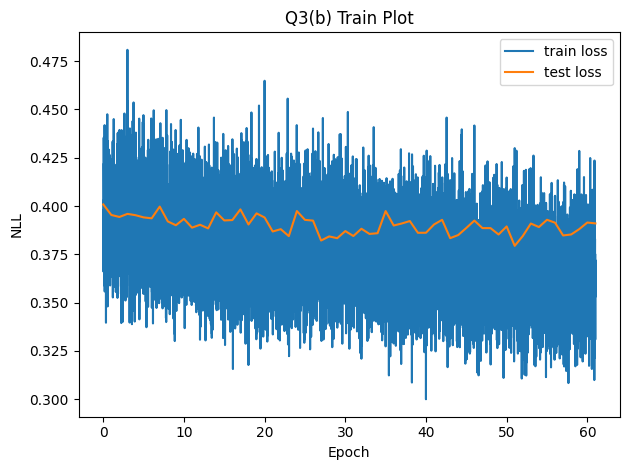

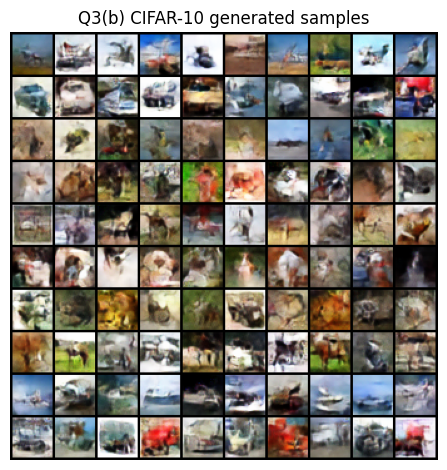

In [11]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [18]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """

    class_num = 10

    patch_size, hidden_size, num_heads, num_layer, epochs, batch_size, lr  = 2, 512, 8, 12, 60, 256, 1e-4
    dropout_prob = 0.1

    C, W, H = 4, 8, 8


    model = DiT(W, patch_size, C, hidden_size, num_heads, dropout_prob, class_num, num_layer)
    DDPM = Diffusion(model).to(device)

    checkpoints = torch.load(os.path.join(
            'Checkpoints', 'ckpt_' + 'q3' + '_' + "90" + ".pt"))
    
    model.load_state_dict(checkpoints["model"])


    model.eval()
    num_samples, steps = 10, 1000
    cfg_scales, samples = [1.0, 1.25, 1.35, 1.5], []

    for cfg_scale in cfg_scales:
        samples_tmp = []
        for i in range(10):
            sample = DDPM.sample3(num_samples, steps, (num_samples, C, H, W), i, cfg_scale)[:num_samples] * checkpoints['std']
            sample = torch.clip(vae.decode(sample).permute(0, 2, 3, 1), -1, 1).cpu().numpy() / 2 + 0.5
            samples_tmp.append(sample)
        samples.append(samples_tmp)
        print(f"the {cfg_scale}'s sample have been finished!!!")

    return np.array(samples)

the 1.0's sample have been finished!!!
the 1.25's sample have been finished!!!
the 1.35's sample have been finished!!!
the 1.5's sample have been finished!!!


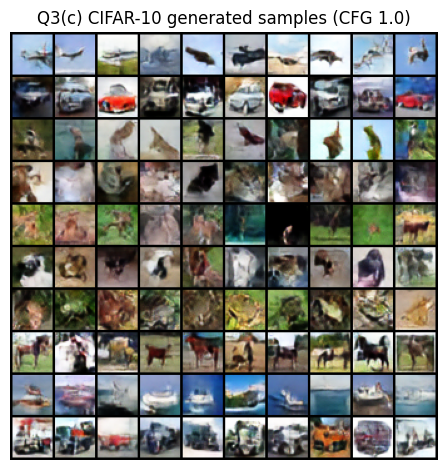

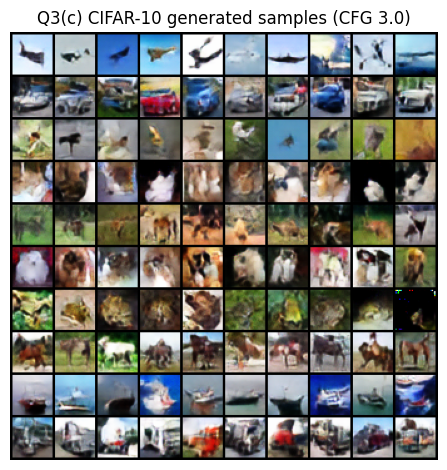

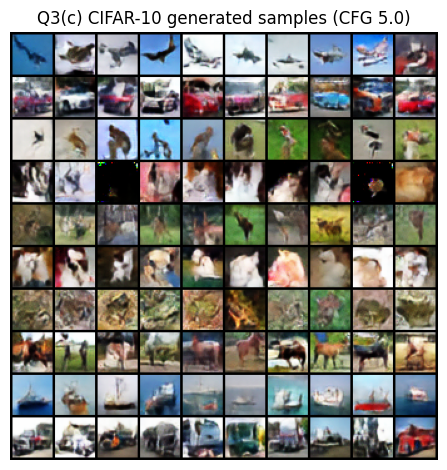

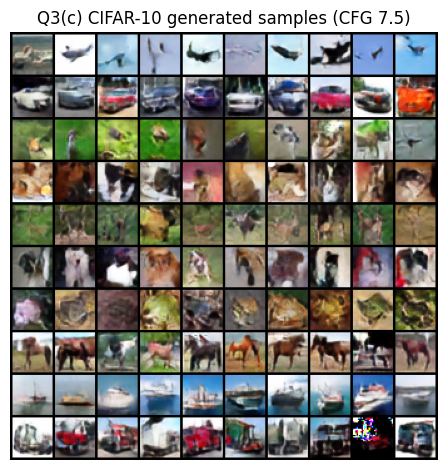

In [19]:
q3c_save_results(q3_c)